In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm 
import pickle
from minisom import MiniSom  
import math


from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples


In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
df_wind = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [4]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,1


In [5]:
# check if each asset has the same amount of rows

assets = df_wind['asset_id'].unique()

for asset in assets:
    current_len = 0
    new_len = len(df_wind[df_wind['asset_id']==asset])
    if new_len != current_len:
        print(f'new length: {new_len}')
        current_len = new_len

new length: 63169
new length: 74023
new length: 70849
new length: 72840
new length: 64801
new length: 75738
new length: 69775
new length: 70948
new length: 74272
new length: 85749
new length: 70506
new length: 75769
new length: 73820
new length: 85093
new length: 66407
new length: 67758
new length: 81080
new length: 84833
new length: 66601
new length: 75457
new length: 69087
new length: 65448
new length: 73588
new length: 70344
new length: 67763
new length: 69012
new length: 67226
new length: 74034
new length: 77338
new length: 70746
new length: 73228
new length: 70439
new length: 60633
new length: 66908
new length: 70188
new length: 72680
new length: 95375
new length: 93104
new length: 96902
new length: 97927
new length: 98693
new length: 97085
new length: 96812
new length: 95957
new length: 97113
new length: 76105
new length: 79892
new length: 75700
new length: 81841
new length: 63558
new length: 70903
new length: 68550
new length: 74341
new length: 71325
new length: 64632
new length

In [6]:
len(df_wind)

5384535

In [7]:
import numpy as np
import pandas as pd

np.random.seed(10)

# Define the desired subset size per asset (adjust as needed)
subset_size_percentage = 1  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_wind['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_wind['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_wind[df_wind['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [8]:
# check if each asset has the same amount of rows

assets = df_subset['asset_id'].unique()
current_len = 0

for asset in assets:
    new_len = len(df_subset[df_subset['asset_id']==asset])
    if new_len != current_len:
        print(f'new length: {new_len}')
        current_len = new_len

new length: 60633


In [9]:
df_subset['asset_id'].nunique()

71

In [10]:
len(df_subset)

4304943

In [11]:
df_subset = df_subset.reset_index(drop=True)

In [12]:
df_subset['read_at'] = pd.to_datetime(df_subset['read_at'])

In [13]:
df_subset['read_at'] = df_subset['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [14]:
X = df_subset[['asset_id','read_at' ,'wind_direction', 'power_average', 'exterior_temperature']]
X.head()

,asset_id,read_at,wind_direction,power_average,exterior_temperature
0,11,1.634675e+09,217.0,340.0,16.0
1,11,1.679212e+09,62.0,13.0,4.0
2,11,1.627686e+09,-78.0,532.0,9.0
3,11,1.640041e+09,177.0,909.0,7.0
4,11,1.659615e+09,-196.0,178.0,26.0


In [15]:
X.dtypes

asset_id                  int64
read_at                 float64
wind_direction          float64
power_average           float64
exterior_temperature    float64
dtype: object

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4304943 entries, 0 to 4304942
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   asset_id              int64  
 1   read_at               float64
 2   wind_direction        float64
 3   power_average         float64
 4   exterior_temperature  float64
dtypes: float64(4), int64(1)
memory usage: 164.2 MB


In [17]:
X = X.astype(np.float32)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4304943 entries, 0 to 4304942
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   asset_id              float32
 1   read_at               float32
 2   wind_direction        float32
 3   power_average         float32
 4   exterior_temperature  float32
dtypes: float32(5)
memory usage: 82.1 MB


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['read_at' ,'wind_direction', 'power_average', 'exterior_temperature']])
X_scaled = pd.DataFrame(X_scaled)

In [20]:
X_scaled['asset_id'] = X['asset_id']

In [21]:
X_grouped = X_scaled.groupby('asset_id')

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

to be able to have actual time series, the data were grouped by asset id. if that is not done the algorithm will assume that every row of the df is a different time series and we would have 43736 time series instead of 77 (the number of assets) (the graphs explain it better:)

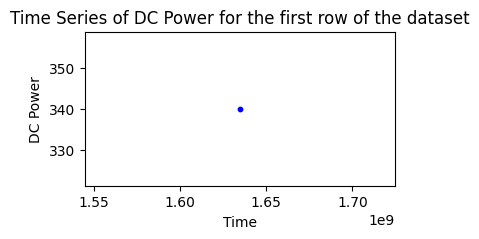

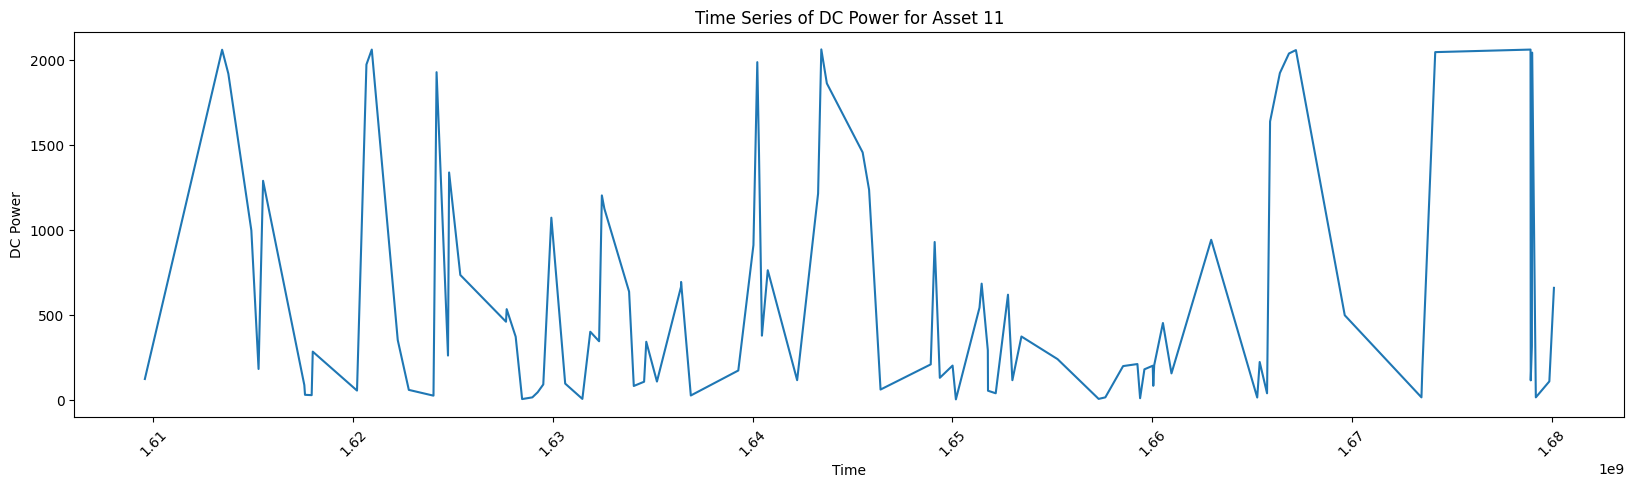

In [22]:
first_row = df_subset.iloc[0]
# Plotting a single dot with custom size
plt.figure(figsize=(4, 2))
plt.scatter(first_row['read_at'], first_row['power_average'], s=10, color='b')
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.title('Time Series of DC Power for the first row of the dataset')
plt.show()

# Selecting the first row and grouping by asset_id
first_group = df_subset[df_subset['asset_id'] == 11][:100]

# Sort the dataframe by 'read_at' column
first_group = first_group.sort_values(by='read_at')

# Plotting the time series
plt.figure(figsize=(20, 5))
plt.plot(first_group['read_at'], first_group['power_average'])
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.title('Time Series of DC Power for Asset 11')
plt.xticks(rotation=45)
plt.show()

In [23]:
X_scaled.columns = ['read_at' ,'wind_direction', 'power_average', 'exterior_temperature', 'asset_id']

In [24]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at' ,'wind_direction', 'power_average', 'exterior_temperature']].values \
                    for _, group in X_scaled.groupby('asset_id')]

In [25]:
X_train = grouped_arrays_all

In [26]:
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train) # --> calculates the mean and variance of each time series and scales the data to have zero mean and unit variance along each time series

X_train = np.array(X_train)

sz = X_train.shape[1]  

In [27]:
train_pca = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components = 2)
train_pca = pca.fit_transform(train_pca)

In [28]:
seed = 42

In [29]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    KM = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    KM = KM.fit(train_pca)
    Sum_of_squared_distances.append(KM.inertia_)

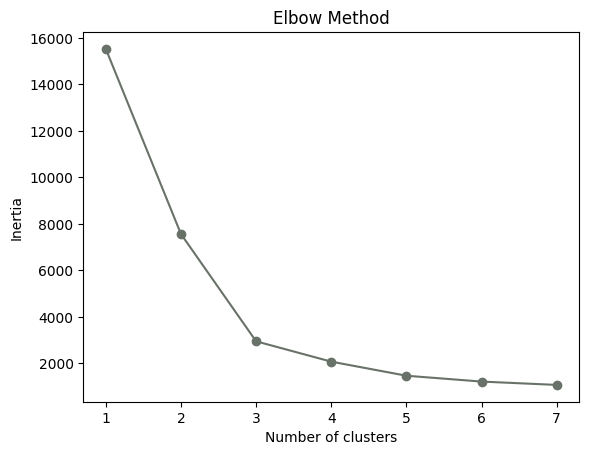

In [30]:
plt.plot(range(1,8), Sum_of_squared_distances, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

by the elbow plot, the optimum number of clusters is 3. we'll also do another analysis with the silhouette score:

For n_clusters = 2 The average silhouette_score is : 0.58
For n_clusters = 3 The average silhouette_score is : 0.57
For n_clusters = 4 The average silhouette_score is : 0.47
For n_clusters = 5 The average silhouette_score is : 0.49
For n_clusters = 7 The average silhouette_score is : 0.48
For n_clusters = 8 The average silhouette_score is : 0.47
For n_clusters = 9 The average silhouette_score is : 0.48


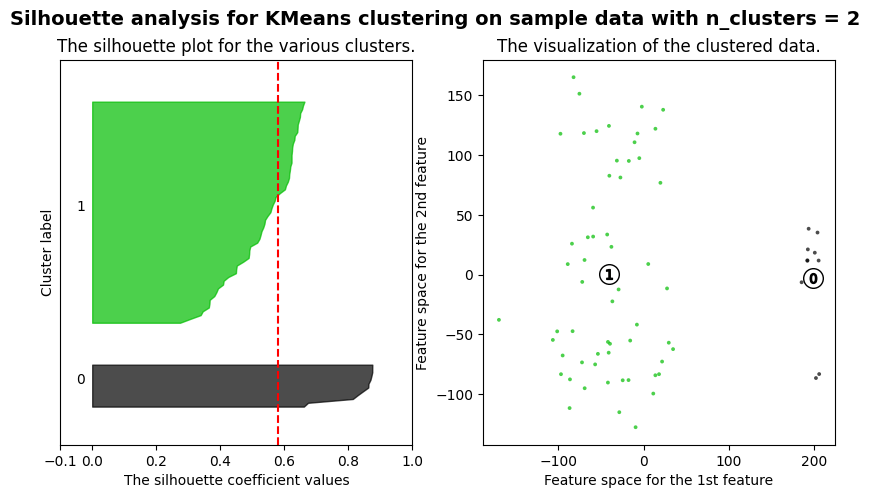

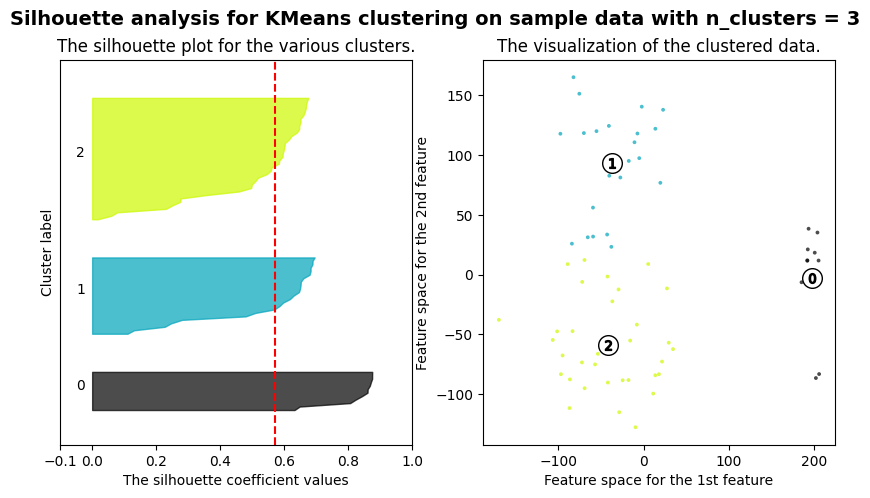

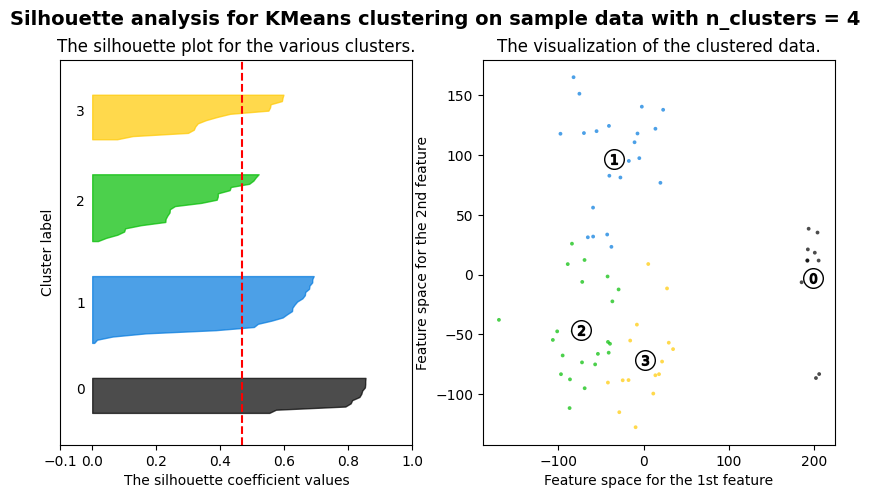

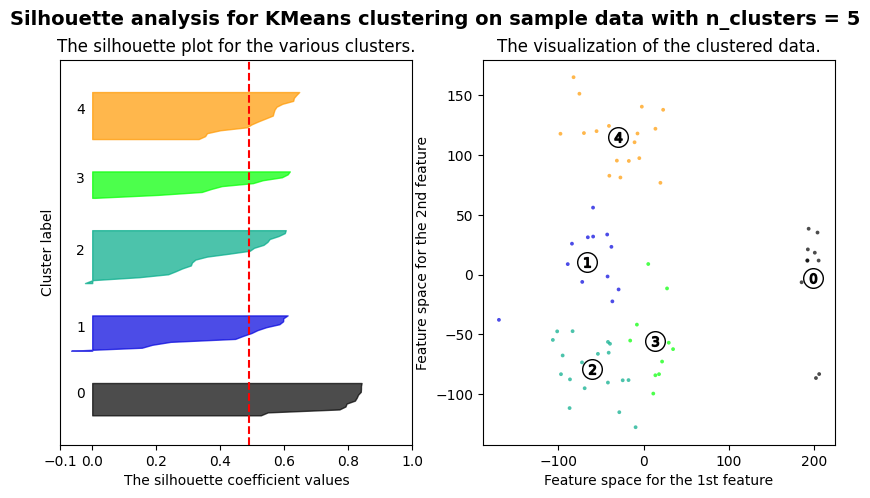

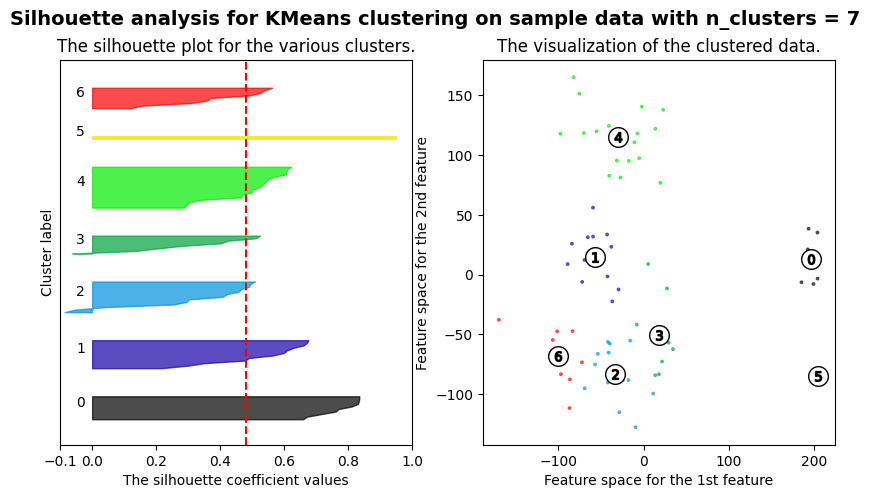

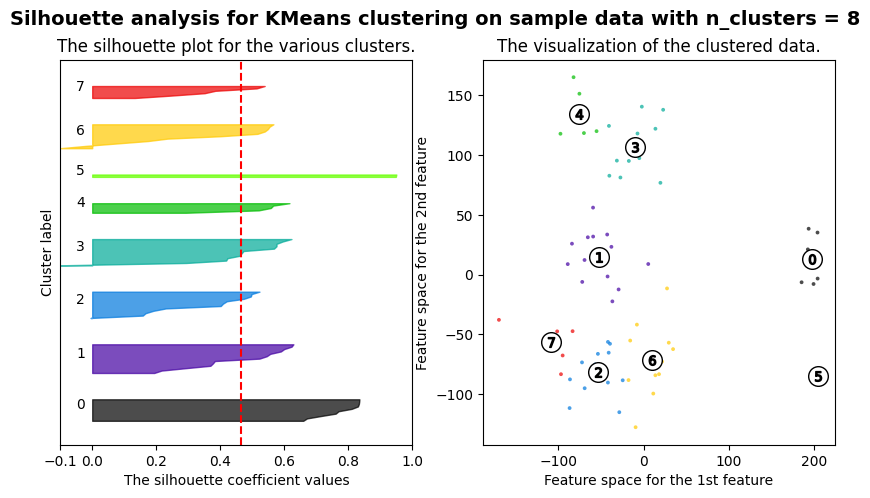

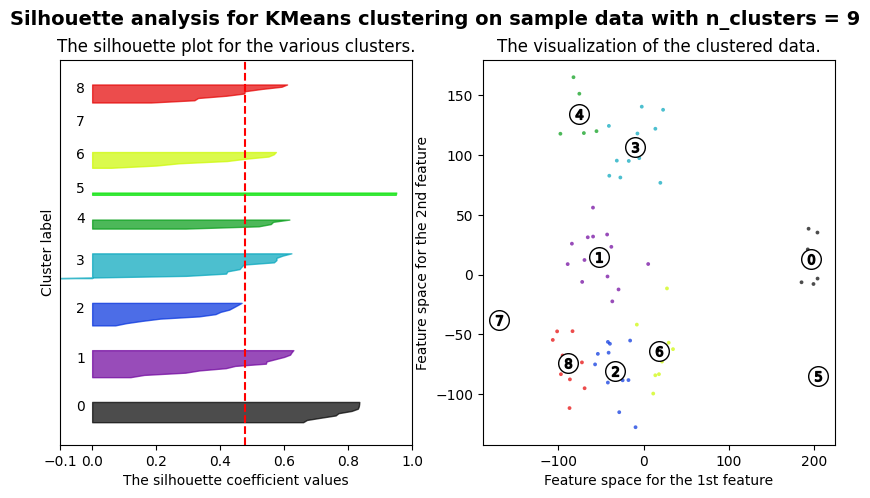

In [31]:
X = train_pca

range_n_clusters = [2,3,4,5,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


we have to look not only to the average silhouette score, but also for the partition that has the best silhouette score for the individual clusters

using 3 clusters as is the best in the silhouette analysis

In [32]:
def zoom_in_plot(X_train, y_pred, cluster_centers, sz, title:str, num_clusters, som: bool = False):
    fig = plt.figure(figsize=(16, 4*num_clusters))
    gs = gridspec.GridSpec(num_clusters, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1] * num_clusters)

    cluster_num = 0
    
    som_to_plot = np.unique(y_pred)

    indexes_to_plot = []

    num_clusters_to_plot = num_clusters
    if som:
        num_clusters_to_plot = len(som_to_plot) 

    for i in range(num_clusters_to_plot):
        cluster_num = som_to_plot[i] if som else i
        
        if cluster_num > len(cluster_centers):
            continue

        # Main plot with more width
        ax = plt.subplot(gs[i, 0])

        for xx in X_train[y_pred == cluster_num]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        if som:
            ax.plot(pca.inverse_transform(cluster_centers)[cluster_num-1].ravel(), "r-")  # Plot cluster centers in original data space
        else:
            ax.plot(pca.inverse_transform(cluster_centers)[cluster_num].ravel(), "r-")  # Plot cluster centers in original data space
        ax.set_xlim(0, sz)
        ax.set_ylim(-5, 6)
        ax.text(0.55, 0.85, 'Cluster %d' % (cluster_num), transform=ax.transAxes)
        if i == 0:
            ax.set_title(f"{title}")

        # Zoomed-in plot
        axins = plt.subplot(gs[i, 2])
        for xx in X_train[y_pred == cluster_num]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        if som:
            axins.plot(pca.inverse_transform(cluster_centers)[cluster_num-1].ravel(), "r-")  # Plot cluster centers in original data space
        else:
            axins.plot(pca.inverse_transform(cluster_centers)[cluster_num].ravel(), "r-")  # Plot cluster centers in original data space
        axins.set_xlim(30000, 30020)
        axins.set_ylim(-4.5, 5)
        x_ticks = [30000, 30005, 30010, 30015, 30020]
        # Set the x-ticks for the zoomed-in plot
        axins.set_xticks(x_ticks)
        plt.xticks(rotation=20)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

Euclidean k-means
3420.360 --> 2973.467 --> 2947.446 --> 2947.446 --> 


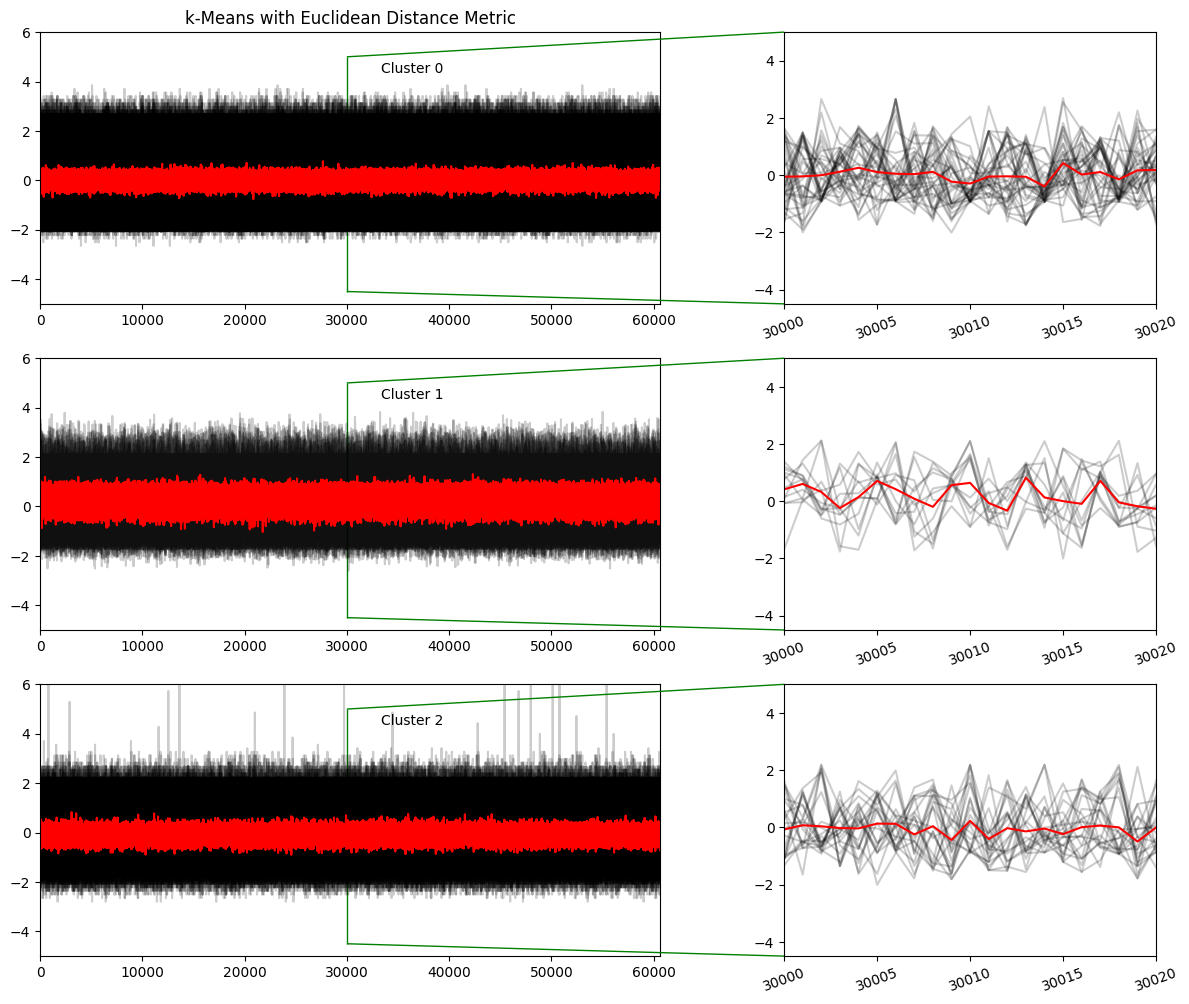

In [33]:
# Euclidean k-means
num_clusters = 3
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=num_clusters, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(train_pca)

cluster_centers_reshaped = km.cluster_centers_.reshape(num_clusters, 2)

zoom_in_plot(X_train, y_pred_euclidean, cluster_centers_reshaped, sz, 'k-Means with Euclidean Distance Metric', num_clusters=num_clusters)


In [34]:
with open('intermediate_without_out/euclidean_wind.pickle', 'wb') as f:
    pickle.dump(km, f)

with open('intermediate_without_out/euclidean_labels_wind.pickle', 'wb') as f:
    pickle.dump(y_pred_euclidean, f)

In [35]:
with open('intermediate_without_out/euclidean_wind.pickle', 'rb') as f:
    km = pickle.load(f)

with open('intermediate_without_out/euclidean_labels_wind.pickle', 'rb') as f:
    y_pred_euclidean = pickle.load(f)

In [36]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [37]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 45, 46, 47, 48, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 413, 414, 415]
Cluster 1: [51, 52, 53, 54, 55, 56, 57, 58, 59, 510, 511, 512]
Cluster 2: [11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 42, 44, 49, 110, 111, 112, 113, 114, 115, 116, 117, 411, 412]


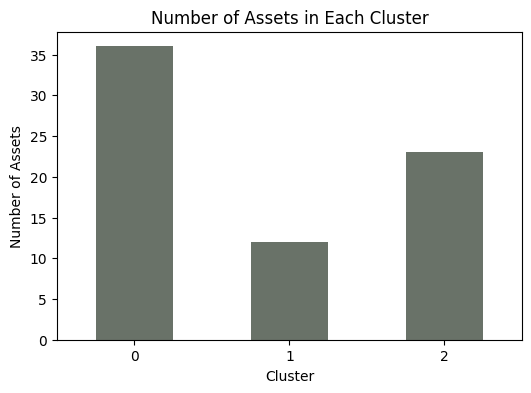

In [38]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [39]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = count

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,36,12,23


In [40]:
merged_df = df_subset.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [41]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_euclidean.csv', index = False)

### k-Means with DTW distance metric

In [42]:
# dtw-k-means
print("dtw k-means")
dtw_km = TimeSeriesKMeans(n_clusters=num_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_dtw = dtw_km.fit_predict(train_pca)

dtw k-means
Init 1
9559.122 --> 8747.257 --> 8500.317 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

8457.230 --> 8433.015 --> 8433.015 --> 
Init 2
4529.167 --> 3008.073 --> 2970.530 --> 2947.446 --> 2947.446 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


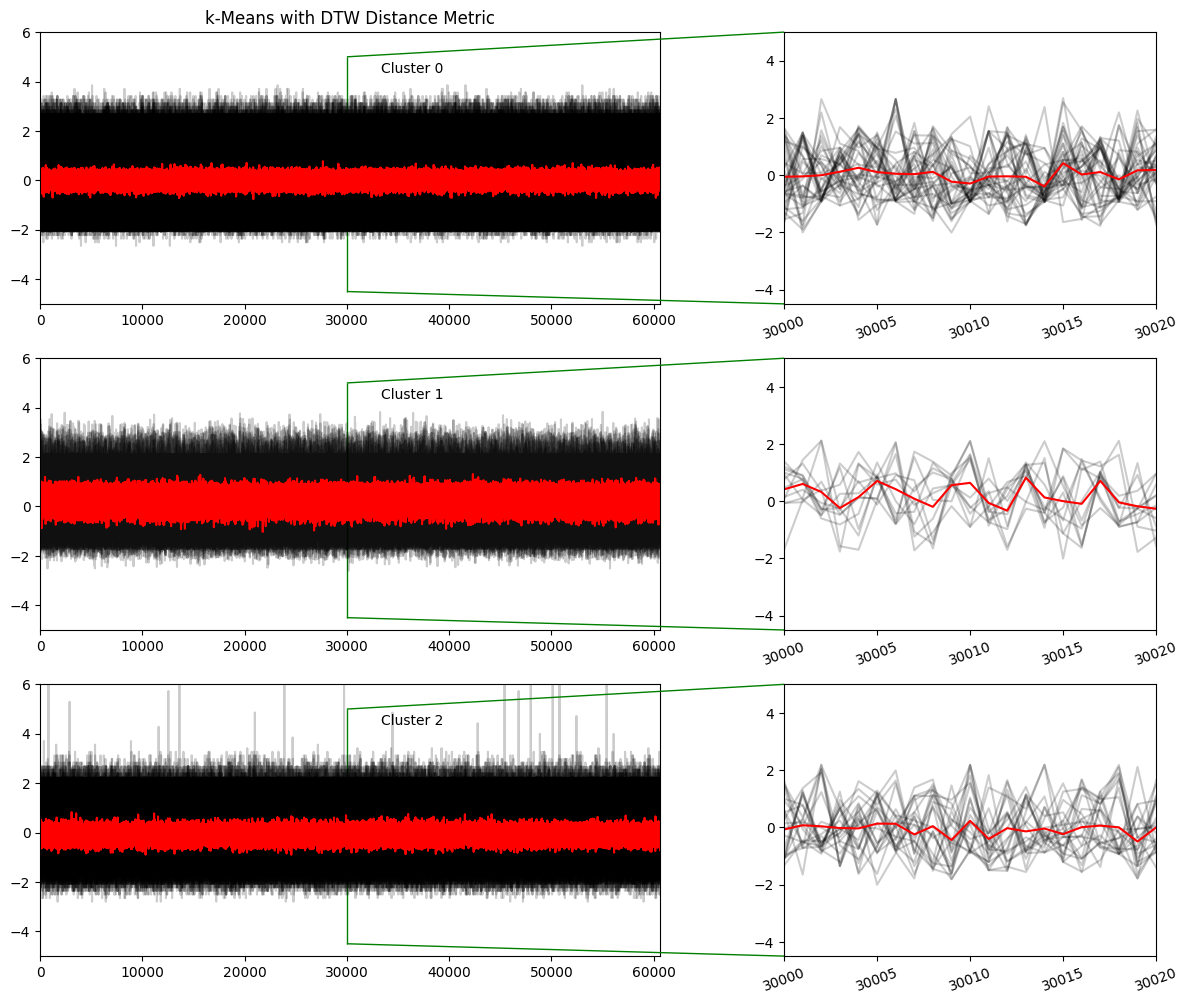

In [43]:
cluster_centers_reshaped = dtw_km.cluster_centers_.reshape(num_clusters, 2)

zoom_in_plot(X_train, y_pred_dtw, cluster_centers_reshaped, sz, 'k-Means with DTW Distance Metric', num_clusters=num_clusters)

In [44]:
with open('intermediate_without_out/dtw_wind.pickle', 'wb') as f:
    pickle.dump(dtw_km, f)

with open('intermediate_without_out/dtw_labels_wind.pickle', 'wb') as f:
    pickle.dump(y_pred_dtw, f)

In [45]:
with open('intermediate_without_out/dtw_wind.pickle', 'rb') as f:
    dtw_km = pickle.load(f)

with open('intermediate_without_out/dtw_labels_wind.pickle', 'rb') as f:
    y_pred_dtw = pickle.load(f)

In [46]:
assets_per_cluster_dtw = pd.DataFrame()

assets_per_cluster_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dtw['cluster_label'] = y_pred_dtw

In [47]:
assets_clusters = assets_per_cluster_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 45, 46, 47, 48, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 413, 414, 415]
Cluster 1: [51, 52, 53, 54, 55, 56, 57, 58, 59, 510, 511, 512]
Cluster 2: [11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 42, 44, 49, 110, 111, 112, 113, 114, 115, 116, 117, 411, 412]


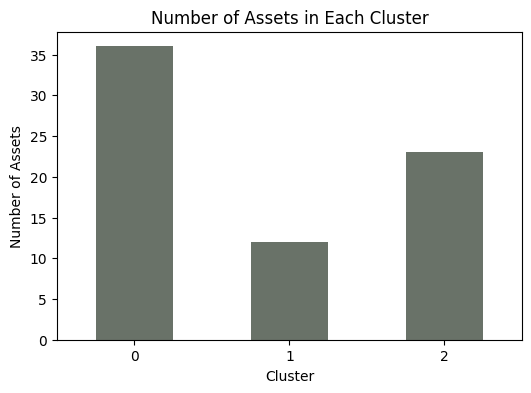

In [48]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [49]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'Dtw'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,36,12,23
1,Dtw,36,12,23


In [50]:
merged_df = df_subset.merge(assets_per_cluster_dtw, on='asset_id', how='left')

In [51]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_dtw.csv', index = False)

## Soft DTW k-means

In [52]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=num_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(train_pca)

Soft-DTW k-means
73316288.499 --> 18271218.493 --> 16992486.265 --> 16645874.966 --> 16234044.249 --> 16234044.249 --> 


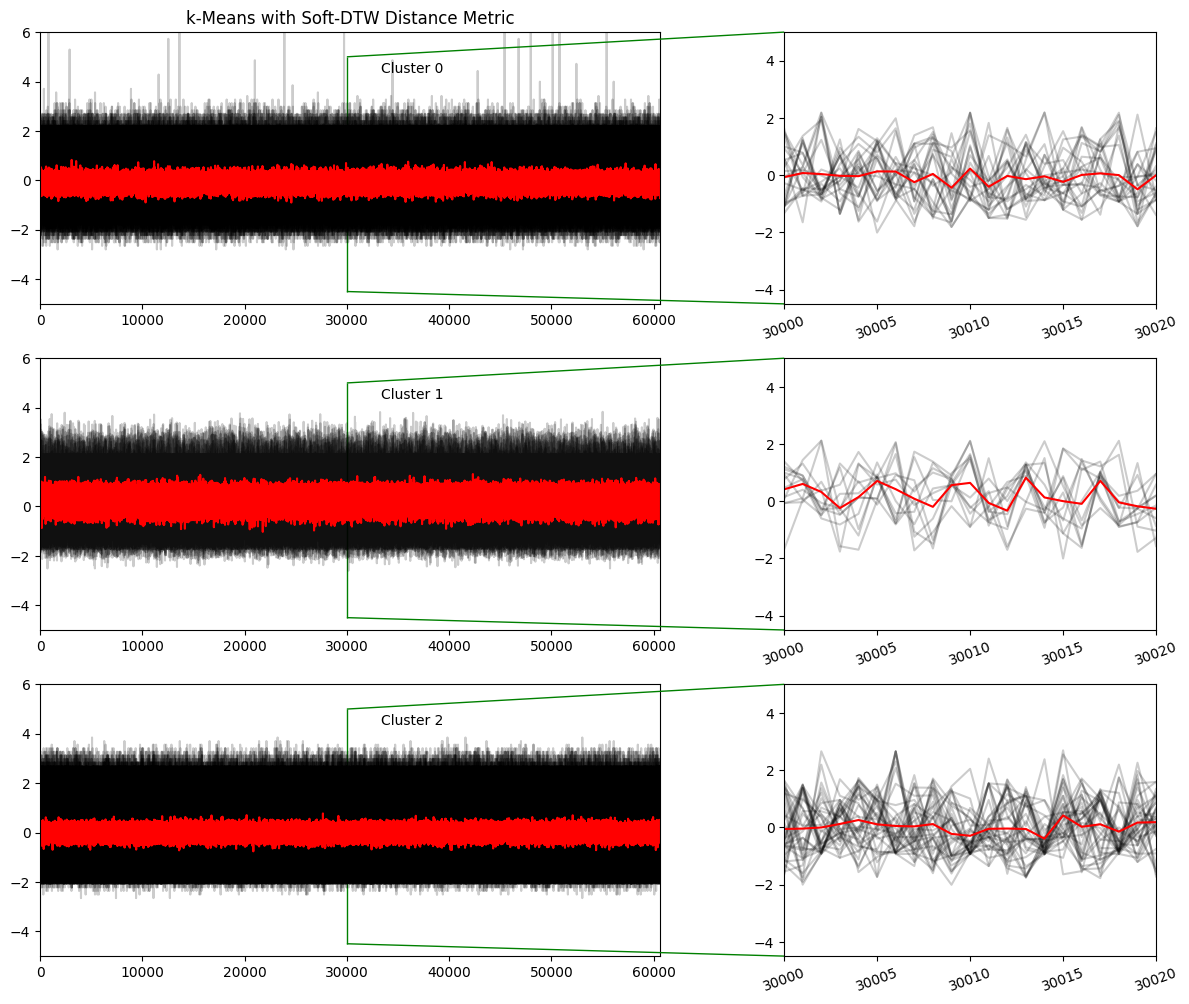

In [53]:
cluster_centers_reshaped = sdtw_km.cluster_centers_.reshape(num_clusters, 2)

#zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'k-Means with Euclidean Distance Metric')
zoom_in_plot(X_train, y_pred_soft_dtw, cluster_centers_reshaped, sz, 'k-Means with Soft-DTW Distance Metric', num_clusters=num_clusters)

In [54]:
with open('intermediate_without_out/SDTW_wind.pickle', 'wb') as f:
    pickle.dump(sdtw_km, f)

with open('intermediate_without_out/SDTW_labels_wind.pickle', 'wb') as f:
    pickle.dump(y_pred_soft_dtw, f)

In [55]:
with open('intermediate_without_out/SDTW_wind.pickle', 'rb') as f:
    sdtw_km = pickle.load(f)

with open('intermediate_without_out/SDTW_labels_wind.pickle', 'rb') as f:
    y_pred_soft_dtw = pickle.load(f)

In [56]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [57]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 0: [11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 42, 44, 49, 110, 111, 112, 113, 114, 115, 116, 117, 411, 412]
Cluster 1: [51, 52, 53, 54, 55, 56, 57, 58, 59, 510, 511, 512]
Cluster 2: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 45, 46, 47, 48, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 413, 414, 415]


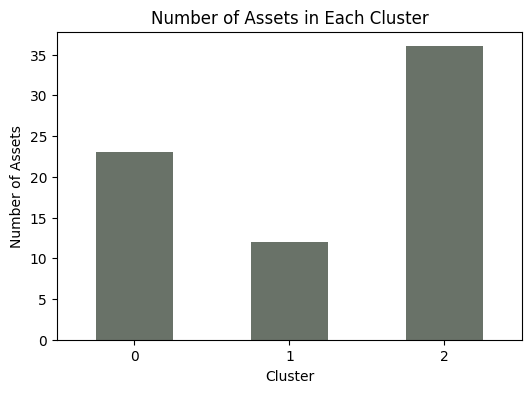

In [58]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [59]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,36,12,23
1,Dtw,36,12,23
2,Soft DTW,23,12,36


In [60]:
merged_df = df_subset.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [61]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_soft_dtw.csv', index = False)

## SOM

In [62]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(train_pca))))

In [63]:
som = MiniSom(som_x, som_y,len(train_pca[0]), sigma=0.1, learning_rate = 2)

som.train(train_pca, 50000)

In [64]:
win_map = som.win_map(train_pca)

In [65]:
cluster_map = []
for idx in range(len(train_pca)):
    winner_node = som.winner(train_pca[idx])
    cluster_map.append((train_pca[idx],winner_node[0]*som_y+winner_node[1]+1))

cluster_df_som = pd.DataFrame(cluster_map,columns=["Series","Cluster"])

In [66]:
cluster_df_som["Cluster"].unique()

array([3, 4, 9, 6, 8, 2])

In [67]:
# Now, you can reshape the cluster centers for visualization
cluster_centers_reshaped = np.array([som.get_weights()[winner_node[0], winner_node[1]] for winner_node in np.ndindex(som_x, som_y)])
cluster_centers_reshaped = cluster_centers_reshaped.reshape((som_x * som_y, len(train_pca[0])))

In [68]:
y_pred_som = np.array(cluster_df_som["Cluster"])

In [69]:
num_clusters = len(cluster_df_som['Cluster'].unique())

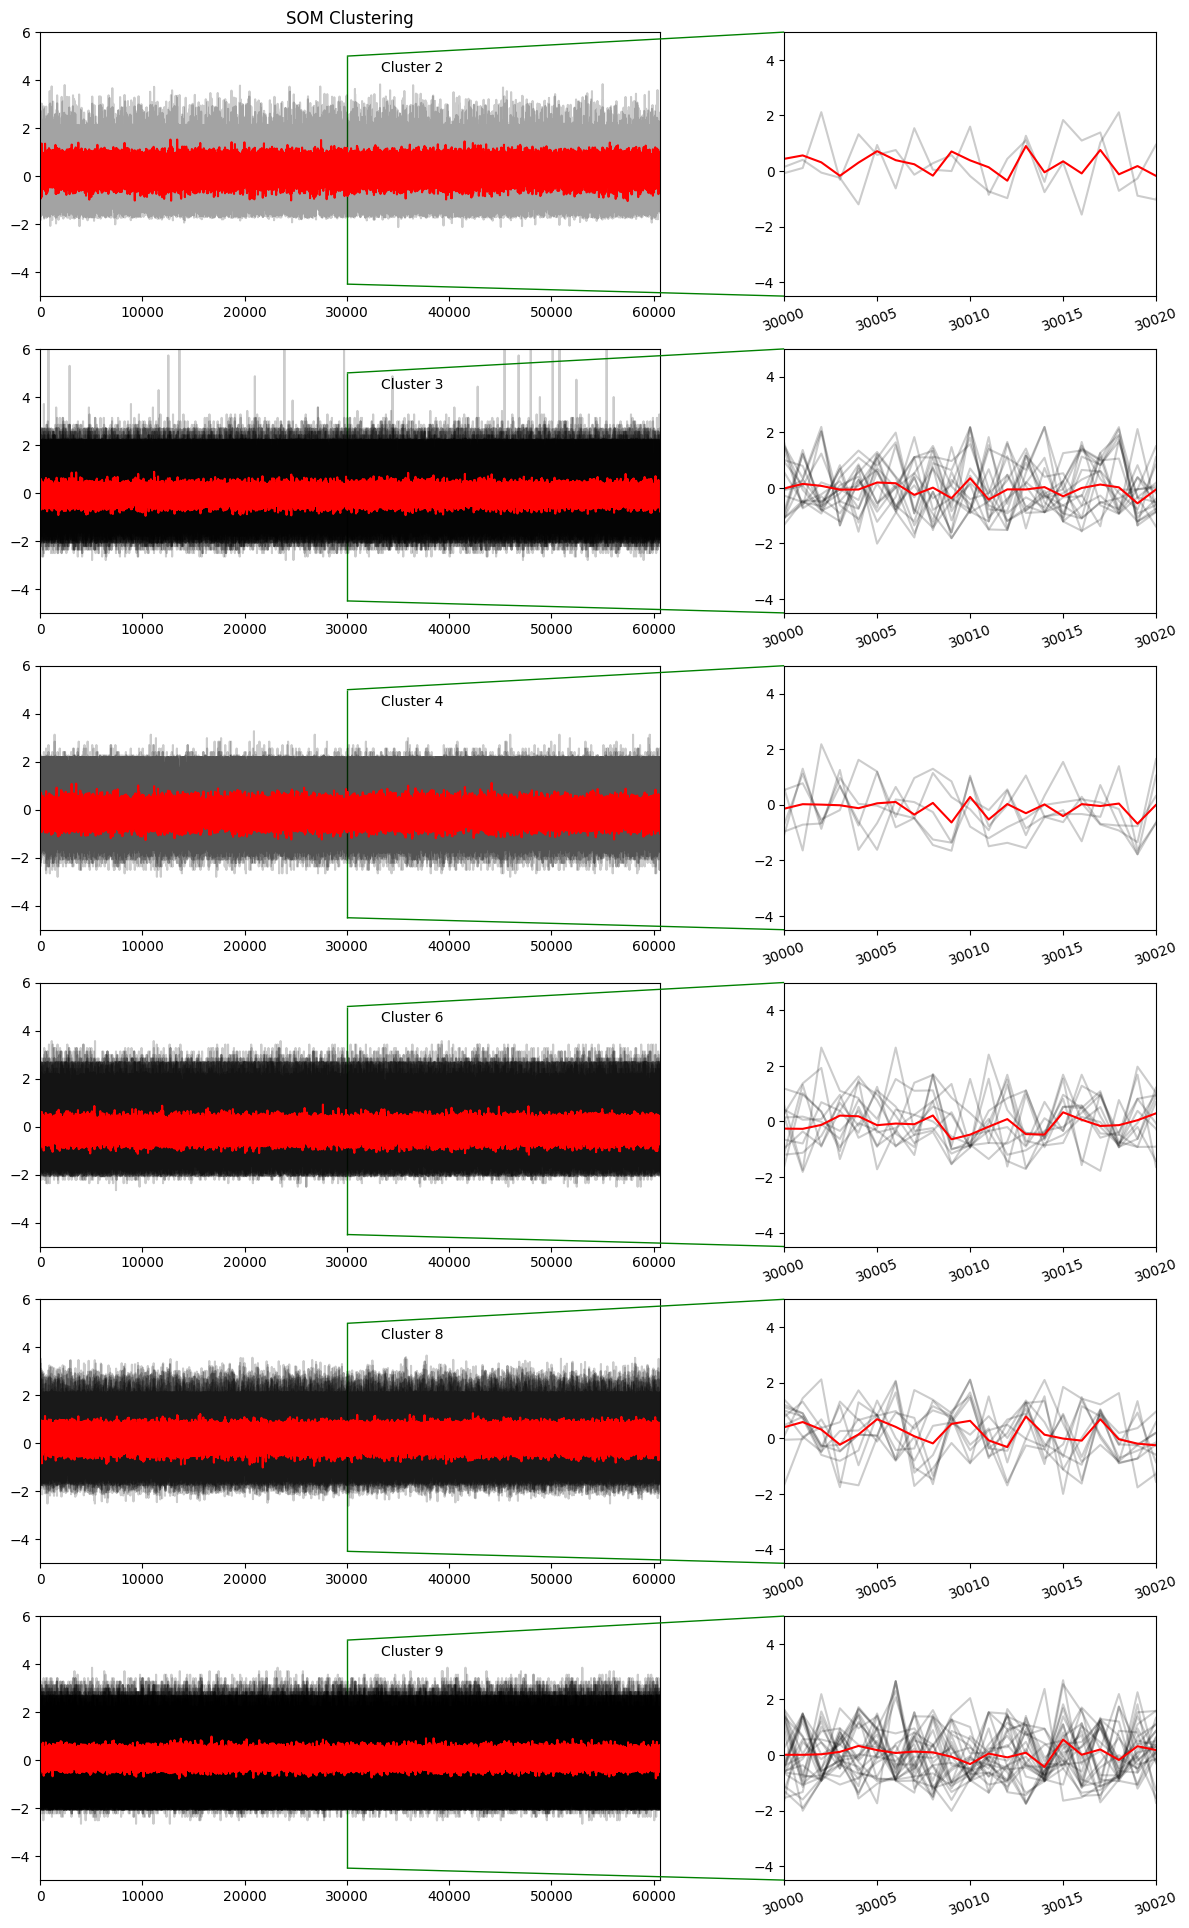

In [70]:
# Assuming you have a function zoom_in_plot defined for plotting
zoom_in_plot(X_train, y_pred_som, cluster_centers_reshaped, sz, 'SOM Clustering', num_clusters=num_clusters, som=True)

In [71]:
assets_per_cluster_som = pd.DataFrame()

assets_per_cluster_som['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_som['cluster_label'] = cluster_df_som['Cluster']

In [72]:
assets_clusters = assets_per_cluster_som.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.tolist()}")

Cluster 2: [57, 511]
Cluster 3: [11, 13, 14, 16, 18, 19, 41, 42, 44, 49, 110, 111, 114, 115, 116, 117, 413]
Cluster 4: [12, 15, 17, 112, 113]
Cluster 6: [36, 37, 45, 47, 48, 311, 313, 411, 412, 414, 415]
Cluster 8: [51, 52, 53, 54, 55, 56, 58, 59, 510, 512]
Cluster 9: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 38, 39, 43, 46, 210, 310, 312, 314, 315, 316, 317, 410]


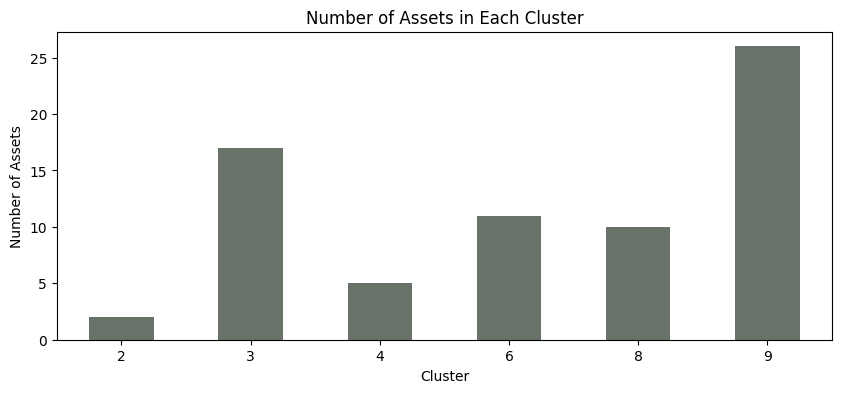

In [73]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_som['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(10, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [74]:
cluster_counts = assets_per_cluster_som['cluster_label'].value_counts().sort_index()

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'
    asset_per_cluster.loc[3, column_name] = f'{count:.0f}'

asset_per_cluster.loc[3, 'Metric'] = 'SOM'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 6,Cluster 8,Cluster 9
0,Euclidean,36,12,23,na,n,na,na,na
1,Dtw,36,12,23,na,n,na,na,na
2,Soft DTW,23,12,36,na,n,na,na,na
3,SOM,NaN,NaN,2,17,5,11,10,26


# Evaluation

In [75]:
def dunn_index(points = train_pca, labels = y_pred_euclidean):
    min_intercluster_distances = []
    max_intracluster_distances = []
    
    for label in np.unique(labels):
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intracluster_distances = pairwise_distances(cluster_points)
            max_intracluster_distances.append(np.max(intracluster_distances))
        
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = points[labels == other_label]
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                min_intercluster_distances.append(np.min(intercluster_distances))
    
    if len(max_intracluster_distances) == 0 or len(min_intercluster_distances) == 0:
        return 0
    
    return min(min_intercluster_distances) / max(max_intracluster_distances)


In [76]:
def xie_beni_index(points = train_pca, labels = y_pred_euclidean):
    # Compute the total scatter
    total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
    # Compute the intra-cluster scatter
    cluster_labels = np.unique(labels)
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = points[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(points)
    
    return intra_cluster_scatter / total_scatter


In [77]:
# Define a function to compute evaluation metrics
def compute_metrics(points = train_pca, labels = y_pred_euclidean, metric = 'euclidean'):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels, metric)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [78]:
labels = {
    'euclidean' : y_pred_euclidean,
    'dtw' : y_pred_dtw,
    'softdtw' : y_pred_soft_dtw
}

metrics_dict = {}

for label, y_pred in labels.items():
    print(f'Computing evaluation metrics for {label} distance metric')

    metrics = compute_metrics(points=train_pca, labels = y_pred, metric = label)

    metrics_dict[label] = metrics

pd.DataFrame(metrics_dict).T


Computing evaluation metrics for euclidean distance metric
Computing evaluation metrics for dtw distance metric


Computing evaluation metrics for softdtw distance metric


,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
euclidean,0.570511,0.554674,145.096261,0.086729,0.002674
dtw,0.570511,0.554674,145.096261,0.086729,0.002674
softdtw,0.752911,0.554674,145.096261,0.086729,0.002674


In [79]:
metrics = compute_metrics(points=train_pca, labels = cluster_df_som['Cluster'], metric = 'dtw')

metrics_dict['SOM'] = metrics

pd.DataFrame(metrics_dict).T

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
euclidean,0.570511,0.554674,145.096261,0.086729,0.002674
dtw,0.570511,0.554674,145.096261,0.086729,0.002674
softdtw,0.752911,0.554674,145.096261,0.086729,0.002674
SOM,0.397390,0.715159,101.539098,0.041168,0.001599
